# <u>Count models, Part 2</u>

Last time, we started talked about modeling <font color="darkorchid">**count variables**</font> &mdash; random variables that can only have <u>_integer_</u> values &mdash; with 2 basic probability distributions:
* <font color="darkorchid">the Poisson distribution</font>, $\operatorname{Pois}(\lambda)$, with PMF $$P( Y = k ) ~ = ~ e^{-\lambda} \, \frac{\lambda^k}{ k! } \quad k = 0, 1, 2, \ldots \ ,$$ and 
* <font color="darkorchid">the negative binomial distribution</font>, $\operatorname{NB}(n,p)$, with PMF $$ P( Y = k ) = \binom{ k+n-1 }{ n-1 } p^{n} \left( 1 - p \right)^{k} \ , \quad k = 0, 1, 2, \ldots \ . $$ This is the probability of needing $k+n$ trials to observe $n$ successes when the chance of success per trial is $p$.

Note carefully that the Poisson distribution is defined by <u>_one parameter_</u>, which is both its mean and its variance, but the negative binomial distribution is defined by <u>_two parameters_</u>; the negative binomial's mean and variance need not be the same. ***This difference is key to choosing the appropriate distribution for modeling!***

For count models, it's more common to reparametrize $\operatorname{NB}(n,p)$ as $\operatorname{NB}(\mu,\alpha)$, for mean $\mu$ and dispersion parameter $\alpha$:  

$$ \sigma^2 ~ = ~ \mu + \alpha \mu^2 \quad \iff \quad \alpha ~ = ~ \frac{\sigma^2 - \mu}{\mu^2} \ . $$

For this NB2 model, here's how these parameters relate to $n$ and $p$:

$$ p ~ = ~ \frac{\mu}{\mu + \sigma^2} ~ = ~ \frac{1}{2 + \alpha \mu} \quad \text{and} \quad n ~ = ~ \frac{\mu^2}{\mu + \sigma^2} ~ = ~ \frac{\mu}{2 + \alpha \mu} \ .$$

Today, we'll see how to incorporate a single predictor variable into a count model to
* consolidate data efficiently,
* make better predictions, and
* understand relationships between the predictor and count variables.

All of this (and more!) is in Chapters 6 and 7 of my Manning book, [Regression: A friendly guide](https://www.manning.com/books/regression-a-friendly-guide), which are under active development. This notebook and the datasets are available in my [regression repo on github](https://github.com/mbrudd/regression) &mdash; please clone and submit comments!

## Libraries and settings

In [1]:
library(tidyverse)
library(MASS)
library(gridExtra)
options(scipen=999)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Births by U.S. county

Last time, we analyzed data from the [National Vital Statistics System](https://www.cdc.gov/nchs/nvss/births.htm) on monthly births for counties in the United States (downloaded directly from [CDC Wonder](https://wonder.cdc.gov/natality-expanded-current.html)) :

In [2]:
births <- read_csv("births.csv", col_types = cols())
births[ sample(1:length(births$county), size=12), ]

county,year,month,births
<chr>,<dbl>,<chr>,<dbl>
"Strafford County, NH",2017,April,37
"Coweta County, GA",2018,August,60
"Seminole County, FL",2016,November,143
"Humboldt County, CA",2018,June,49
"Kennebec County, ME",2018,June,41
"Blair County, PA",2017,October,48
"Lebanon County, PA",2016,April,70
"Carroll County, MD",2016,July,54
"Cache County, UT",2019,June,117


Obviously, there will be more births per month in counties with more people, so it's only natural to combine this data with county population data:

In [3]:
county_pops <- read_csv("county_pops.csv", col_types = cols())
county_pops[ sample(1:length(county_pops$county), size=12), ]

county,Pop2010
<chr>,<dbl>
"Polk County, TN",16825
"Rockingham County, NH",295223
"Pierce County, WA",795225
"Taylor County, WI",20689
"Leslie County, KY",11310
"Richmond city, VA",204214
"Glades County, FL",12884
"Cedar County, MO",13982
"Pickett County, TN",5077


Let's join this data and then see what we've got:

In [4]:
births <- left_join( births, county_pops, by="county" ) 
births[ sample(1:length(births$county), size=12), ]

county,year,month,births,Pop2010
<chr>,<dbl>,<chr>,<dbl>,<dbl>
"Kent County, MI",2016,August,383,602622
"Anchorage Borough, AK",2017,September,155,NA
"Lee County, AL",2018,May,61,140247
"Brunswick County, NC",2017,May,39,107431
"Chesapeake city, VA",2018,March,108,222209
"Honolulu County, HI",2019,February,486,953207
"Randolph County, NC",2019,March,45,141752
"Citrus County, FL",2018,September,34,141236
"Dane County, WI",2017,April,217,488073


In [5]:
length( unique( births$county) )

[1] 578

In [6]:
county_birth_stats <- births %>% 
  group_by(county) %>% 
  summarize(N=n(), Mean=mean(births), Var=var(births), Ratio = Mean/Var)
head( county_birth_stats )

county,N,Mean,Var,Ratio
<chr>,<int>,<dbl>,<dbl>,<dbl>
"Ada County, ID",48,180.95833,324.63652,0.5574183
"Adams County, CO",48,279.27083,778.88254,0.3585532
"Adams County, PA",48,31.77083,42.98892,0.7390470
"Aiken County, SC",48,55.54167,66.80674,0.8313782
"Alachua County, FL",48,123.64583,139.42509,0.8868263
"Alamance County, NC",48,69.79167,168.29610,0.4146957


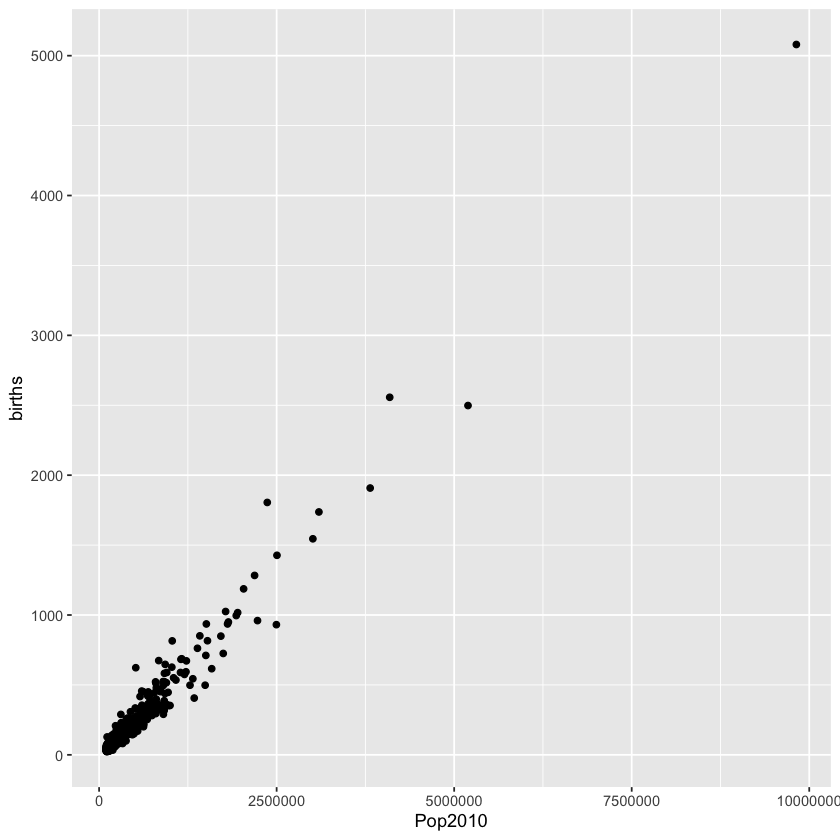

In [7]:
births_apr_2016 <- births %>% filter( year=="2016", month=="April") %>% drop_na()
ggplot( births_apr_2016, aes(Pop2010,births)) + geom_point()

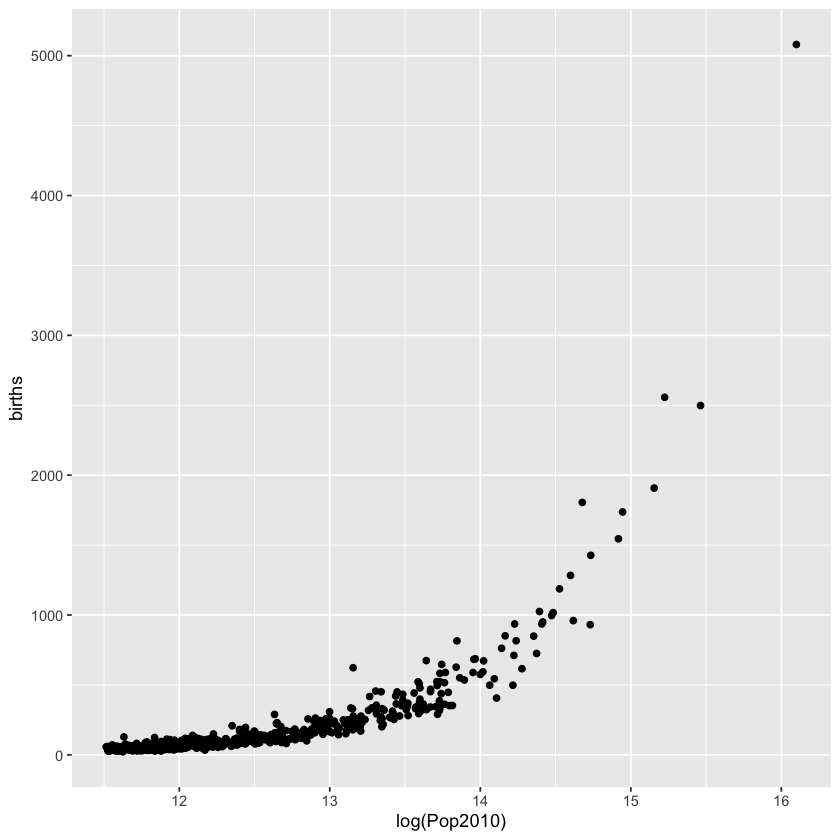

In [8]:
ggplot( births_apr_2016, aes(log(Pop2010),births)) + geom_point()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



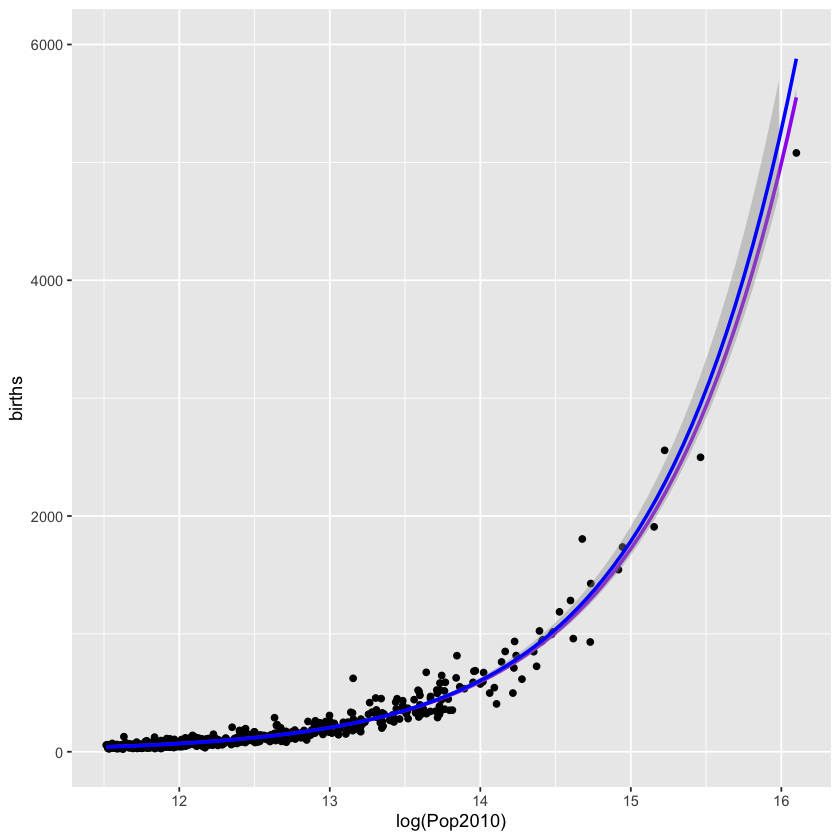

In [9]:
ggplot( births_apr_2016, aes(log(Pop2010),births)) + 
  geom_point() + 
  geom_smooth(method="glm", method.args=list(family="poisson"), color="purple") + 
  geom_smooth(method="glm.nb", color="blue") + ylim(0,6000)

In [10]:
( pois_counties <- county_birth_stats %>% filter( abs(Ratio-1) < 0.10 ) )
pois_births <- births %>% filter( county %in% pois_counties$county )

county,N,Mean,Var,Ratio
<chr>,<int>,<dbl>,<dbl>,<dbl>
"Ascension Parish, LA",48,51.81250,54.15559,0.9567342
"Atlantic County, NJ",48,111.83333,114.09929,0.9801405
"Blount County, TN",48,32.25000,32.31915,0.9978604
"Boone County, KY",48,51.68750,53.07048,0.9739407
"Brazos County, TX",48,92.14583,101.10594,0.9113790
"Catawba County, NC",48,68.66667,71.41844,0.9614697
"Clay County, FL",48,94.31250,101.32580,0.9307847
"Cowlitz County, WA",48,40.37500,36.92021,1.0935744
"Cumberland County, PA",48,120.02083,127.16977,0.9437843


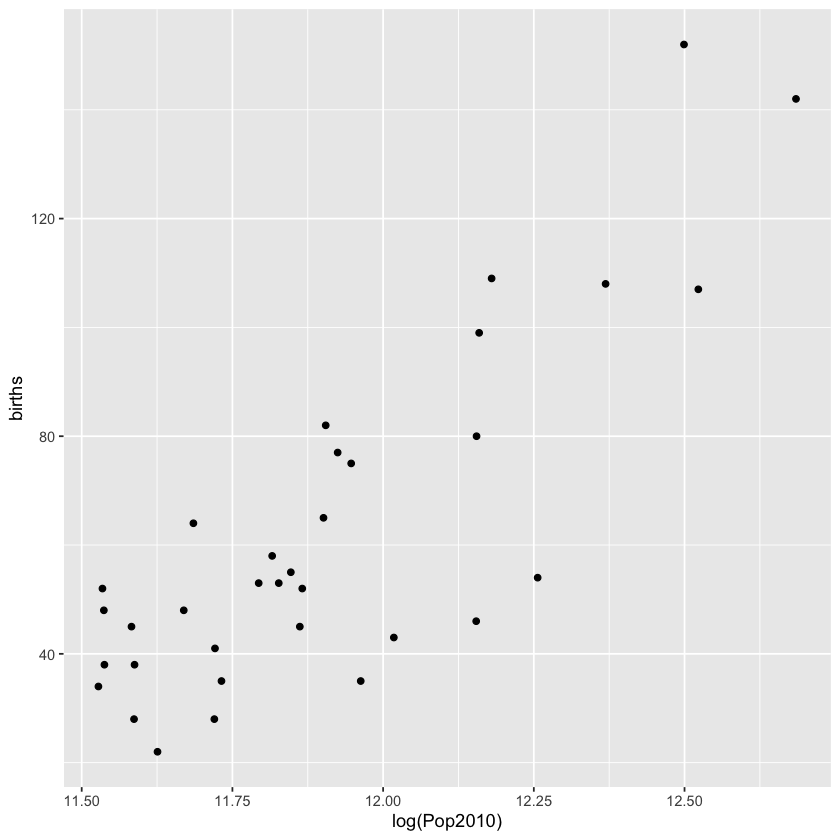

In [11]:
births_apr_2016_pois <- pois_births %>% filter( year == 2016, month == "April" )
ggplot( births_apr_2016_pois, aes(log(Pop2010),births)) + 
  geom_point() 

`geom_smooth()` using formula 'y ~ x'



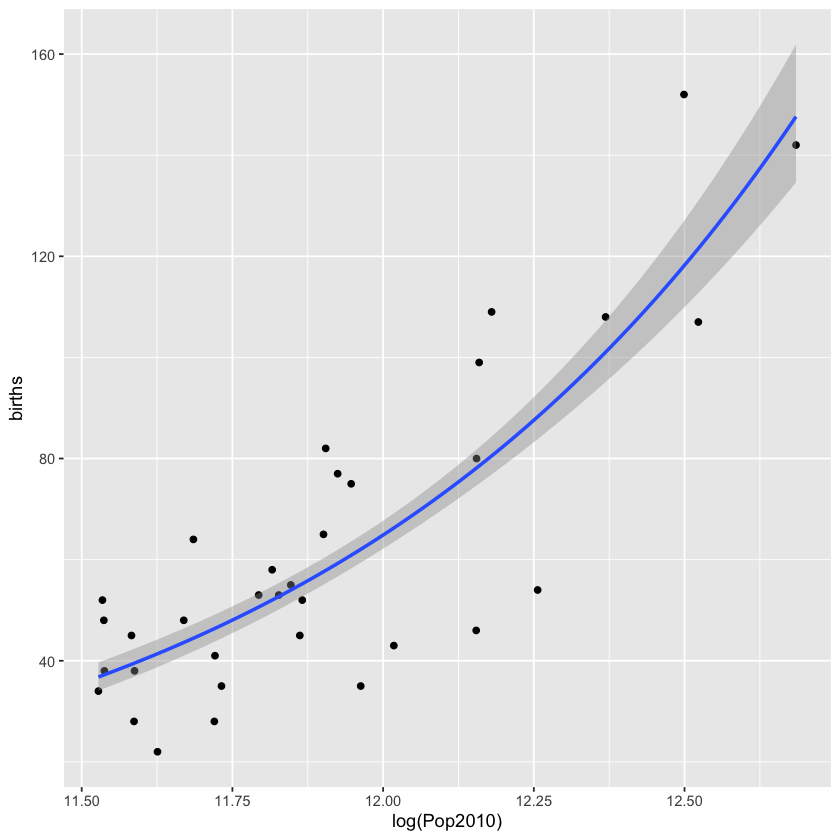

In [12]:
ggplot( births_apr_2016_pois, aes(log(Pop2010),births)) + 
  geom_point() + 
  geom_smooth(method="glm", method.args=list(family="poisson"))

In [13]:
births_apr_2016_pois_fit <- glm( births ~ log(Pop2010), data = births_apr_2016_pois, family="poisson")
summary(births_apr_2016_pois_fit)


Call:
glm(formula = births ~ log(Pop2010), family = "poisson", data = births_apr_2016_pois)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9346  -1.3760   0.1321   1.5102   3.0106  

Coefficients:
              Estimate Std. Error z value            Pr(>|z|)    
(Intercept)  -10.23570    0.76635  -13.36 <0.0000000000000002 ***
log(Pop2010)   1.20067    0.06368   18.85 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 477.76  on 33  degrees of freedom
Residual deviance: 144.80  on 32  degrees of freedom
AIC: 348.03

Number of Fisher Scoring iterations: 4


There's our first count regression model! For these 34 counties, the fitted model says that

$$\log{ ( \text{Average number of births per month} ) } ~ = ~ -10.2357 + 1.20067 \times \log{ ( \text{Population} ) } $$

which is probably easier to interpret after exponentiating:

$$ \text{Average number of births per month} ~ = ~ e^{-10.2357} \times \text{Population}^{1.20067} ~ = ~ 0.0000359 \times \text{Population}^{1.20067} \ .$$

In other words, for these counties, 

$$\operatorname{Pois}\left( \ 0.0000359 \times \text{Population}^{1.20067} \ \right) $$ 

models monthly birth numbers! 

Here's a quick way to explore and test the model:

In [14]:
( test_county <- slice_sample( births_apr_2016_pois ) )

county,year,month,births,Pop2010
<chr>,<dbl>,<chr>,<dbl>,<dbl>
"Catawba County, NC",2016,April,75,154358


In [15]:
( test_mean <- predict( births_apr_2016_pois_fit, newdata = test_county, type="response") )

1 
60.86877

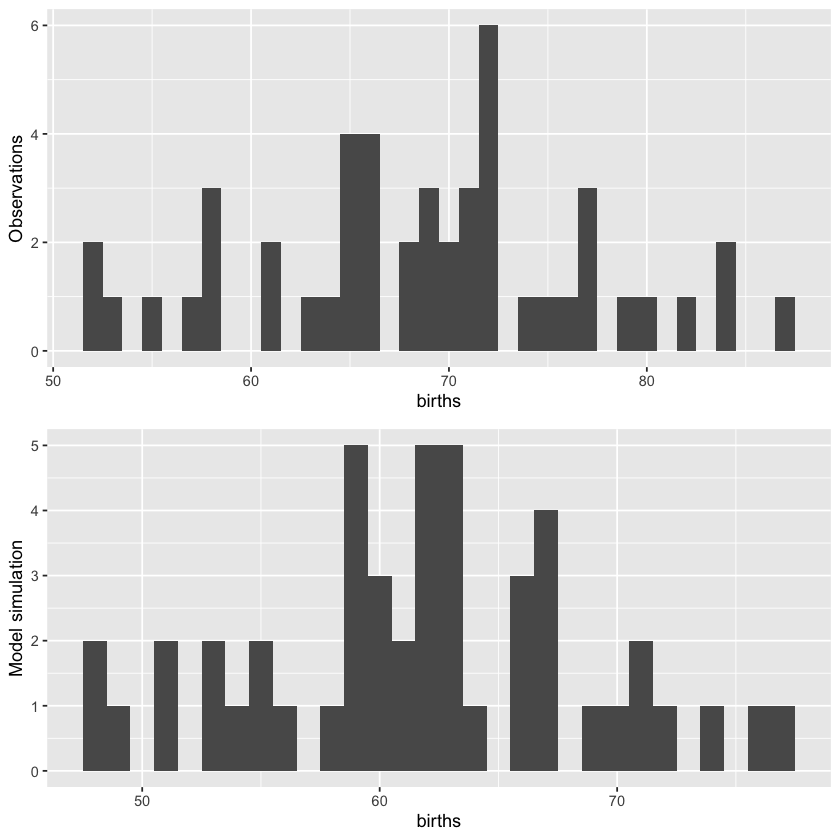

In [16]:
test_county_births <- births %>% filter(county == test_county$county)
tcb_hist <- ggplot( test_county_births, aes(births)) + geom_histogram( binwidth=1 ) + labs(y="Observations")
test_county_model <- data.frame( births = rpois(length(test_county_births$births), test_mean) )
tcm_hist <- ggplot( test_county_model, aes(births)) + geom_histogram( binwidth=1 ) + labs(y="Model simulation")
grid.arrange( tcb_hist, tcm_hist )

We only considered a small subset of counties &mdash; what about the others? 

Poisson regression models simultaneously estimate means and variances for count variables, by the very nature of Poisson distributions. There's no hope that these models will work for count variables whose means and variances differ &mdash; so how do we build a model that estimates averages if we need two parameters?

## Monthly car crashes 

To answer this last question, let's revisit another dataset we discussed before: traffic accidents per month for the counties in my home state of Tennessee ([data available from TDOT](https://www.tn.gov/safety/stats/crashdata.html)).

In [17]:
crashes <- read_csv("TDOT.csv", col_types = cols())
head( crashes )

County,Year,January,February,March,April,May,June,July,August,September,October,November,December
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Anderson,2010,138,113,169,169,155,152,165,176,178,169,179,152
Bedford,2010,71,72,77,70,87,99,90,91,86,118,105,95
Benton,2010,21,23,27,32,34,29,16,43,31,50,29,36
Bledsoe,2010,5,1,3,3,5,1,7,4,3,6,4,3
Blount,2010,126,159,171,145,153,139,201,264,338,267,316,269
Bradley,2010,201,197,203,241,253,226,216,186,179,264,240,251


In [18]:
crash_stats <- crashes %>% 
  dplyr::select(-Year) %>%
  pivot_longer(!County, names_to="Month", values_to="Crashes") %>%
  group_by(County) %>% 
  drop_na(Crashes) %>%
  summarize( N=n(),
             Mean = mean(Crashes),
             Var = var(Crashes), 
             Ratio = Mean/Var)
head(crash_stats)

County,N,Mean,Var,Ratio
<chr>,<int>,<dbl>,<dbl>,<dbl>
Anderson,132,157.022727,511.610167,0.3069187
Bedford,132,92.568182,240.247224,0.3853039
Benton,132,29.000000,41.694656,0.6955328
Bledsoe,132,7.022727,9.518563,0.7377928
Blount,132,261.477273,1910.984212,0.1368286
Bradley,132,252.075758,1174.833912,0.2145629


In [19]:
head( crash_stats %>% arrange( desc( Ratio )) )

County,N,Mean,Var,Ratio
<chr>,<int>,<dbl>,<dbl>,<dbl>
Meigs,132,13.712121,15.198936,0.9021764
Lewis,132,15.939394,18.225307,0.8745748
Wayne,132,23.795455,29.675399,0.8018579
Lake,132,4.280303,5.577319,0.7674481
Cannon,132,22.719697,29.913197,0.7595209
Moore,132,8.901515,11.799387,0.7544049


In [20]:
meigs <- crashes %>% 
            filter(County == "Meigs" ) %>% 
            dplyr::select(January:December) %>% 
            pivot_longer(everything(), names_to="Month", values_to="Crashes")
head( meigs )

Month,Crashes
<chr>,<dbl>
January,11
February,8
March,10
April,14
May,18
June,12


Warning message:
“Removed 2 rows containing missing values (geom_bar).”


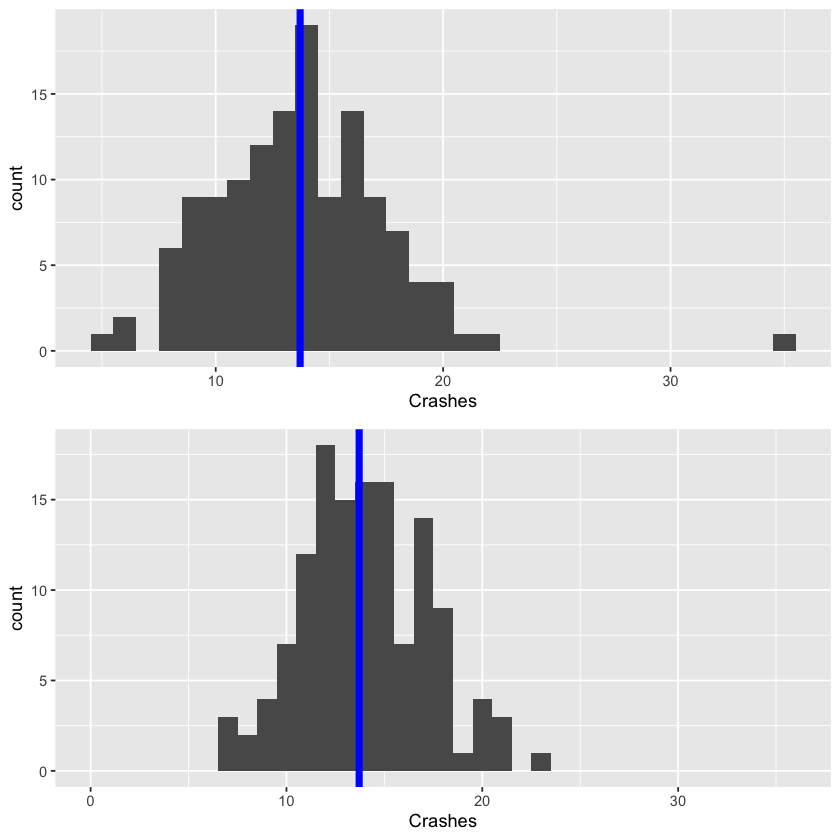

In [21]:
meigs.crashes <- ggplot( meigs, aes(Crashes)) + 
                    geom_histogram( binwidth=1 ) + 
                    geom_vline( xintercept = mean( meigs$Crashes), color="blue", lwd=2)
meigs.model <- data.frame( "Crashes" = rpois(length(meigs$Crashes), mean(meigs$Crashes)) )
meigs.model.hist <- ggplot( meigs.model, aes(Crashes)) + geom_histogram(binwidth=1) + 
                    geom_vline( xintercept = mean( meigs$Crashes), color="blue", lwd=2) +
                    xlim(0,36)
grid.arrange( meigs.crashes, meigs.model.hist, ncol=1)

The punchline: the Poisson distribution $\operatorname{Pois}(13.7)$ is a decent model for monthly crashes in Meigs county. Not so for other counties in Tennessee &mdash; as with monthly births, many of their means and variances are quite different.

It's therefore natural to work with negative binomial distributions as models. We'll relate the average response to population, but how do we manage the variances for these distributions? Let's see... 

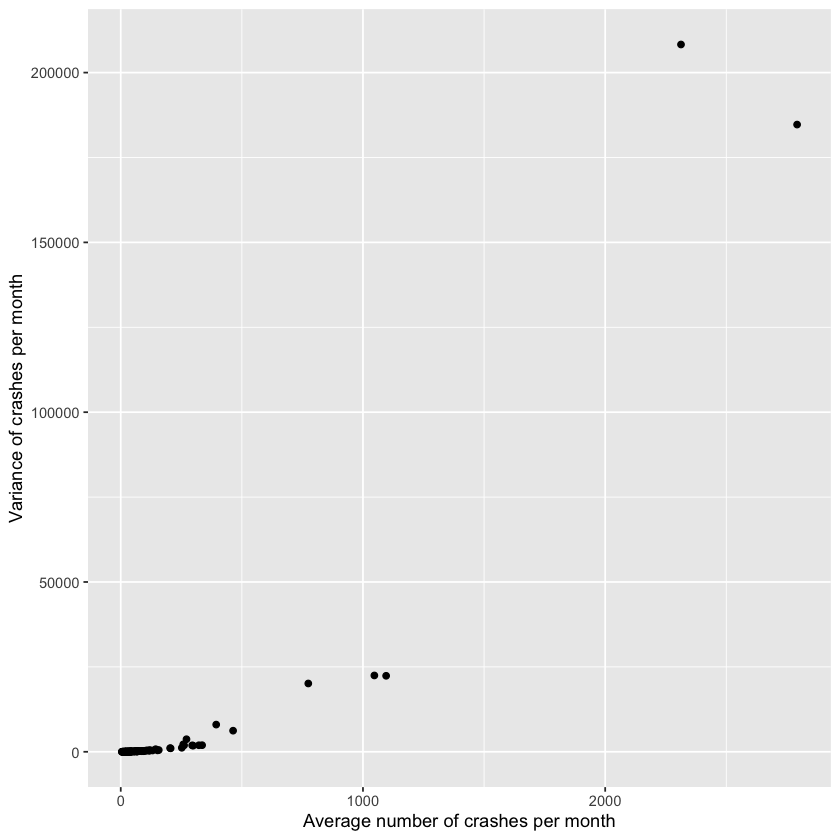

In [22]:
ggplot( crash_stats, aes(x=Mean, y=Var)) + 
  geom_point() + 
  labs( x = "Average number of crashes per month",
          y = "Variance of crashes per month") 

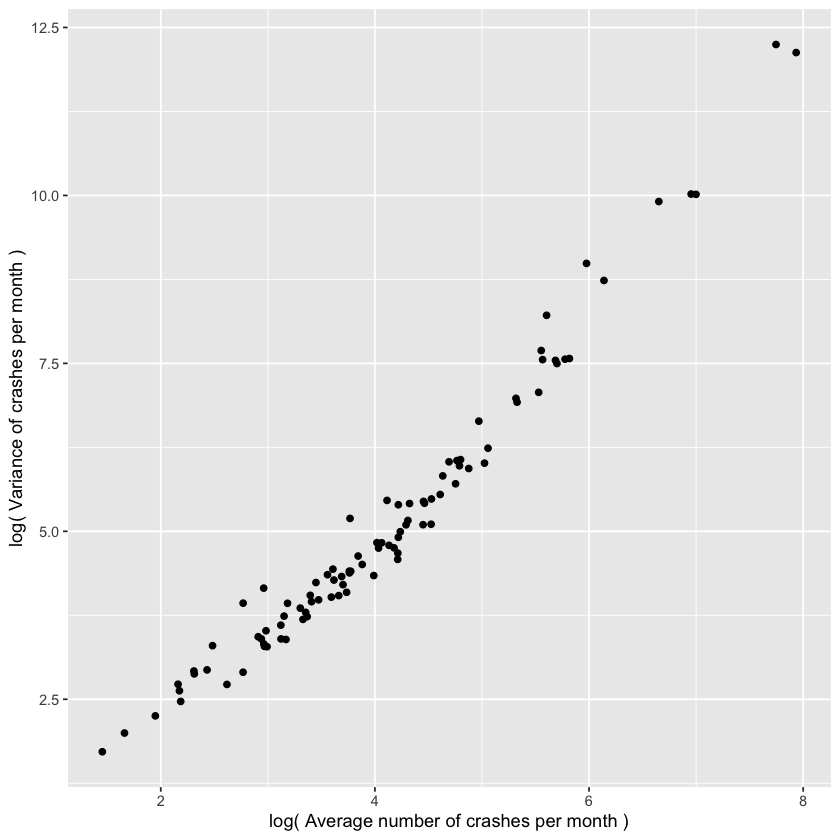

In [23]:
ggplot( crash_stats, aes(x=log(Mean), y=log(Var))) + 
  geom_point() + 
  labs( x = "log( Average number of crashes per month )",
        y = "log( Variance of crashes per month )") 

`geom_smooth()` using formula 'y ~ x'



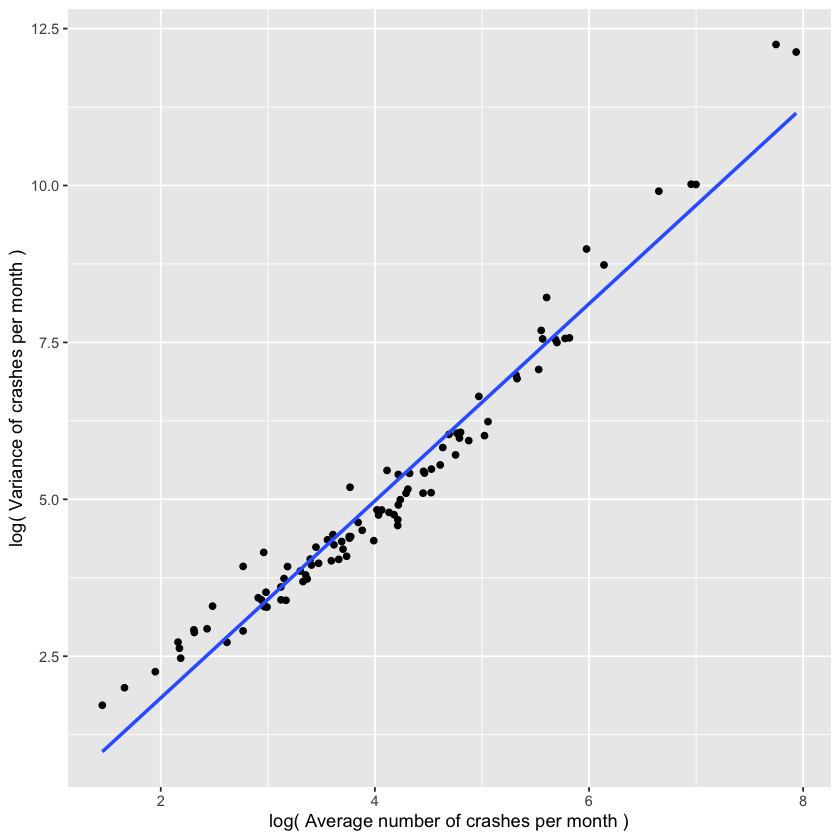

In [24]:
ggplot( crash_stats, aes(x=log(Mean), y=log(Var))) + 
  geom_point() + 
  labs( x = "log( Average number of crashes per month )",
        y = "log( Variance of crashes per month )") +
  geom_smooth( method = "lm", level=0 )

In [25]:
crash_lm <- lm( log(Var) ~ log(Mean), data = crash_stats )
summary(crash_lm)


Call:
lm(formula = log(Var) ~ log(Mean), data = crash_stats)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7271 -0.2816 -0.1103  0.2011  1.3896 

Coefficients:
            Estimate Std. Error t value             Pr(>|t|)    
(Intercept) -1.30534    0.14614  -8.932   0.0000000000000372 ***
log(Mean)    1.57009    0.03424  45.856 < 0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4251 on 93 degrees of freedom
Multiple R-squared:  0.9576,	Adjusted R-squared:  0.9572 
F-statistic:  2103 on 1 and 93 DF,  p-value: < 0.00000000000000022


This tells us that 

$$ \log{ \left( \text{Variance of monthly crashes} \right) } ~ = ~ -1.30534 + 1.57009 \times \log{ \left( \text{Mean of monthly crashes} \right) } \ , $$

so that 

$$ \text{Variance of monthly crashes} ~ = ~ e^{-1.30534} \times \text{Mean of monthly crashes}^{1.57009} ~ = ~ 0.271 \times \text{Mean of monthly crashes}^{1.57009}\ .$$

Very roughly, 

$$ \text{Variance of monthly crashes} \propto \left(\text{Mean of monthly crashes}\right)^{2} \ , $$

which is the relationship at the core of the NB2 model!

A visual check:

`geom_smooth()` using formula 'y ~ x'



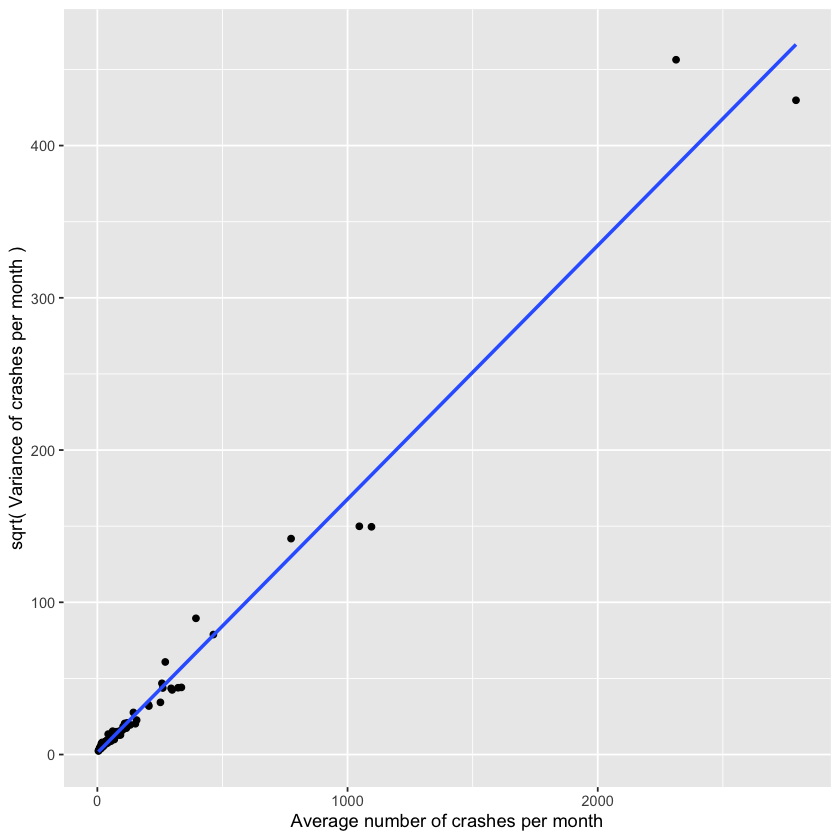

In [26]:
ggplot( crash_stats, aes(x=Mean, y=sqrt(Var))) + 
  geom_point() + 
  labs( x = "Average number of crashes per month",
        y = "sqrt( Variance of crashes per month )") + geom_smooth(method="lm",level=0)

In [27]:
tn_county_pops <- read_csv("tn_county_pops.csv", col_types = cols()) %>%
  filter(CTYNAME != "Tennessee") %>%
  mutate(county = gsub(" County","",CTYNAME)) %>%
  dplyr::select(-CTYNAME) %>%
  dplyr::select(county, Pop2010 = CENSUS2010POP)
head( tn_county_pops )

county,Pop2010
<chr>,<dbl>
Anderson,75129
Bedford,45058
Benton,16489
Bledsoe,12876
Blount,123010
Bradley,98963


In [28]:
crashes_apr_2016 <- crashes %>% 
  filter(Year=="2016") %>% 
  dplyr::select(county=County, crashes=April) %>% drop_na()
crashes_apr_2016 <- left_join( crashes_apr_2016, tn_county_pops, by="county")
head( crashes_apr_2016 )

county,crashes,Pop2010
<chr>,<dbl>,<dbl>
Anderson,177,75129
Bedford,81,45058
Benton,21,16489
Bledsoe,7,12876
Blount,313,123010
Bradley,271,98963


Warning message:
“Removed 1 rows containing missing values (geom_point).”


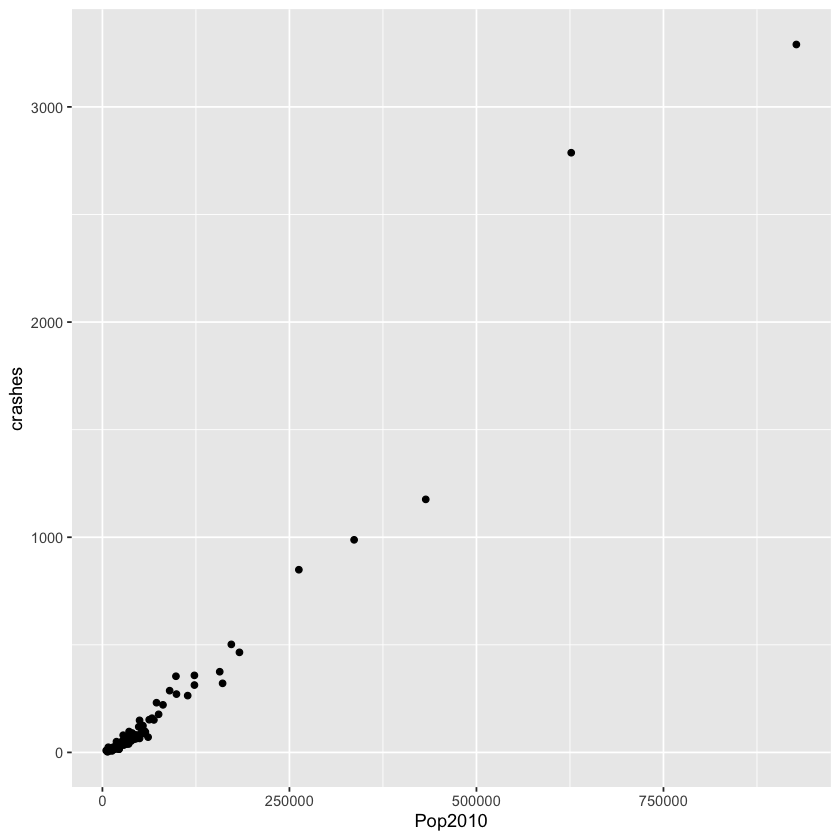

In [29]:
ggplot( crashes_apr_2016, aes(Pop2010,crashes)) + geom_point() # + geom_smooth(method="glm.nb",level=0)

Warning message:
“Removed 1 rows containing missing values (geom_point).”


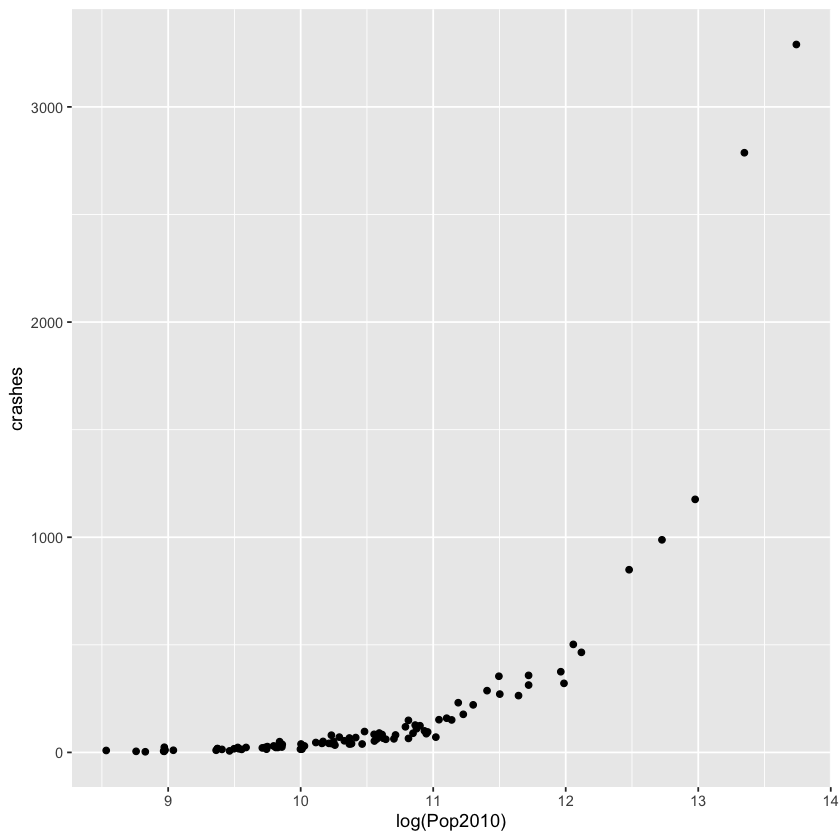

In [30]:
ggplot( crashes_apr_2016, aes(log(Pop2010),crashes)) + geom_point() # + geom_smooth(method="glm.nb",level=0)

In [31]:
crashes_nb_fit <- glm.nb( crashes ~ log(Pop2010), data=crashes_apr_2016 )
theta <- crashes_nb_fit$theta
( alpha <- 1/theta )
summary( crashes_nb_fit )

[1] 0.05628019


Call:
glm.nb(formula = crashes ~ log(Pop2010), data = crashes_apr_2016, 
    init.theta = 17.76824146, link = log)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.40185  -0.88219  -0.02567   0.51454   3.06000  

Coefficients:
             Estimate Std. Error z value            Pr(>|z|)    
(Intercept)  -9.24373    0.31185  -29.64 <0.0000000000000002 ***
log(Pop2010)  1.27847    0.02899   44.09 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(17.7682) family taken to be 1)

    Null deviance: 3140.63  on 93  degrees of freedom
Residual deviance:  100.51  on 92  degrees of freedom
  (1 observation deleted due to missingness)
AIC: 815.78

Number of Fisher Scoring iterations: 1


              Theta:  17.77 
          Std. Err.:  3.64 

 2 x log-likelihood:  -809.78 

And now we have a negative binomial regression model! The fitted model says that

$$ \log{ \left( \text{Average number of crashes} \right) } ~ = ~ -9.24373 + 1.27847 \times \log{ \left( \text{Population} \right) } \ , $$

i.e., 

$$ \text{Average number of crashes} ~ = ~ 0.0000967 \times \left( \text{Population} \right)^{1.27847} \ .$$

What's more, the value of $\theta$, namely $\theta = 17.77$, yields the dispersion parameter:

$$ \alpha ~ = ~ \frac{1}{\theta} ~ = ~ \frac{1}{17.77} ~ = ~ 0.0563 \ ,$$

so we know how to estimate the variance for each estimated mean. That's the NB2 model!

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



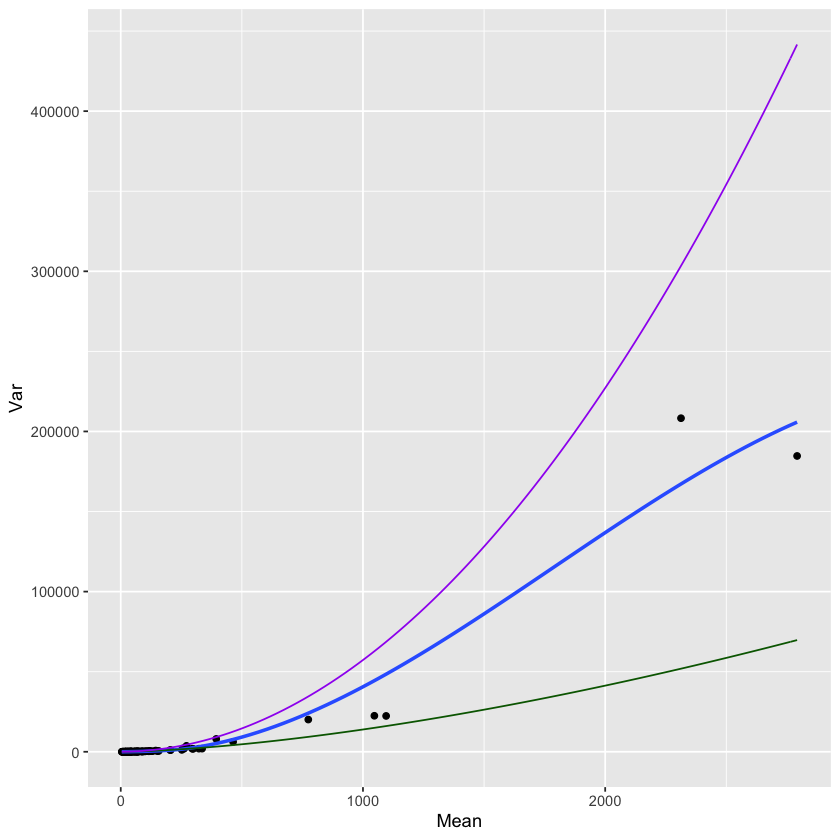

In [32]:
ggplot( crash_stats, aes(x=Mean,y=Var)) + 
  geom_point() + 
  geom_smooth( level=0 ) +
  geom_function(fun = function(x) exp(-1.305)*x^1.570, color="darkgreen" ) +
  geom_function(fun = function(x) x + alpha*x^2, color="purple" ) 

In [33]:
crashes_apr_2016_small <- crashes_apr_2016 %>%
  filter( crashes < 800 )

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


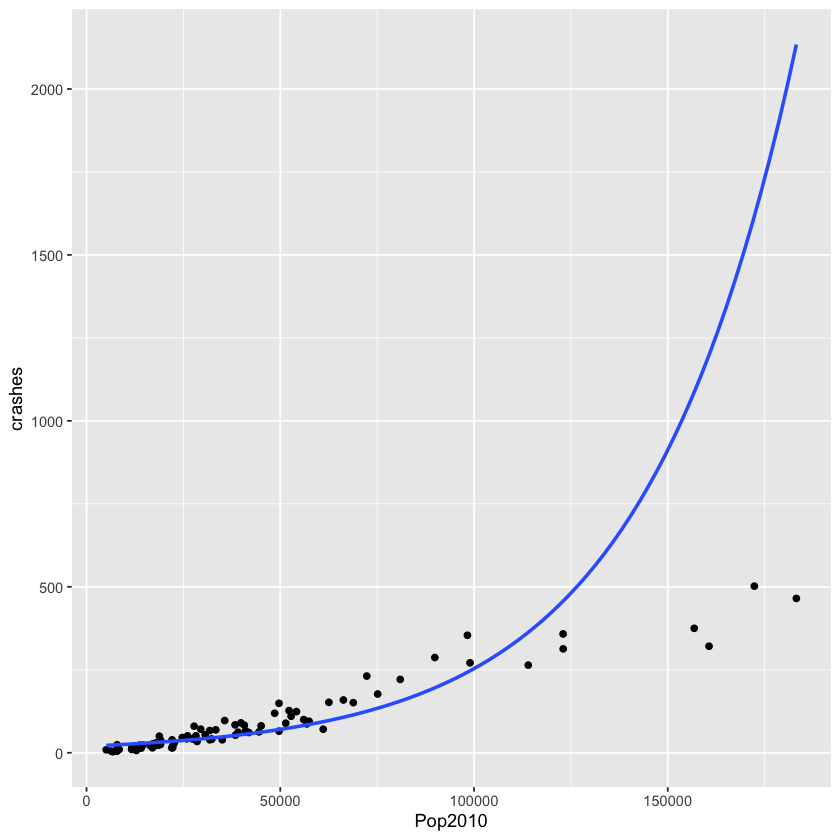

In [34]:
ggplot( crashes_apr_2016_small, aes(Pop2010,crashes)) + geom_point() + geom_smooth(method="glm.nb",level=0)

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


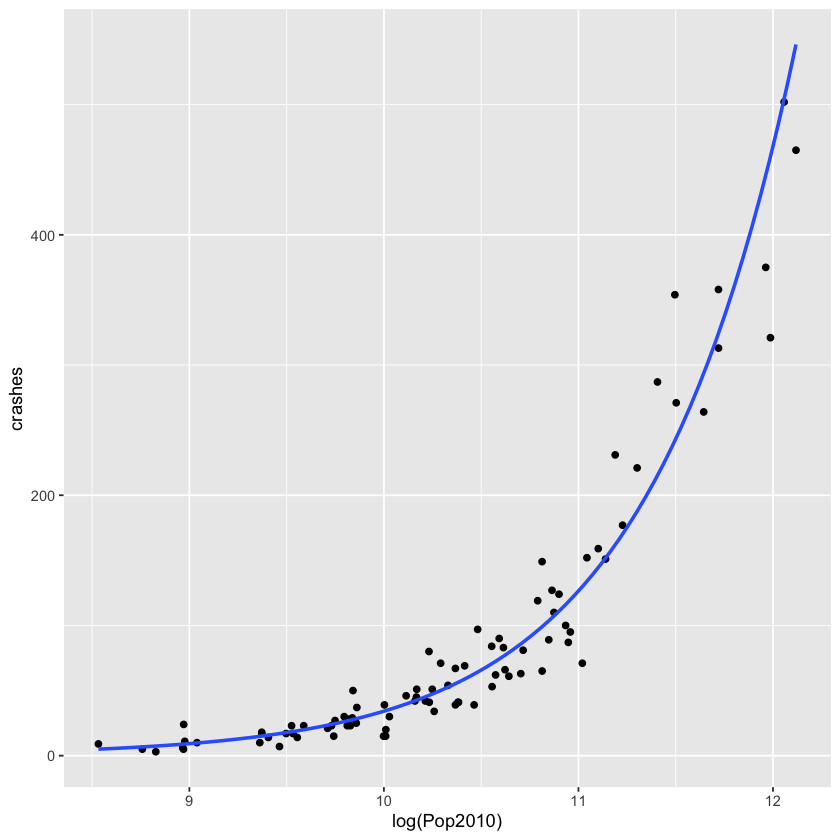

In [35]:
ggplot( crashes_apr_2016_small, aes(log(Pop2010),crashes)) + geom_point() + geom_smooth(method="glm.nb",level=0)

In [36]:
crashes_nb_fit_small <- glm.nb( crashes ~ log(Pop2010), data=crashes_apr_2016_small )
( theta <- crashes_nb_fit_small$theta )
( alpha <- 1/theta )
summary( crashes_nb_fit_small )

[1] 17.0668

[1] 0.05859328


Call:
glm.nb(formula = crashes ~ log(Pop2010), data = crashes_apr_2016_small, 
    init.theta = 17.0668048, link = log)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.34733  -0.83848  -0.01931   0.52761   3.16125  

Coefficients:
             Estimate Std. Error z value            Pr(>|z|)    
(Intercept)  -9.55297    0.42129  -22.68 <0.0000000000000002 ***
log(Pop2010)  1.30843    0.03992   32.77 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(17.0668) family taken to be 1)

    Null deviance: 1388.443  on 88  degrees of freedom
Residual deviance:   94.734  on 87  degrees of freedom
  (1 observation deleted due to missingness)
AIC: 744.13

Number of Fisher Scoring iterations: 1


              Theta:  17.07 
          Std. Err.:  3.62 

 2 x log-likelihood:  -738.131 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



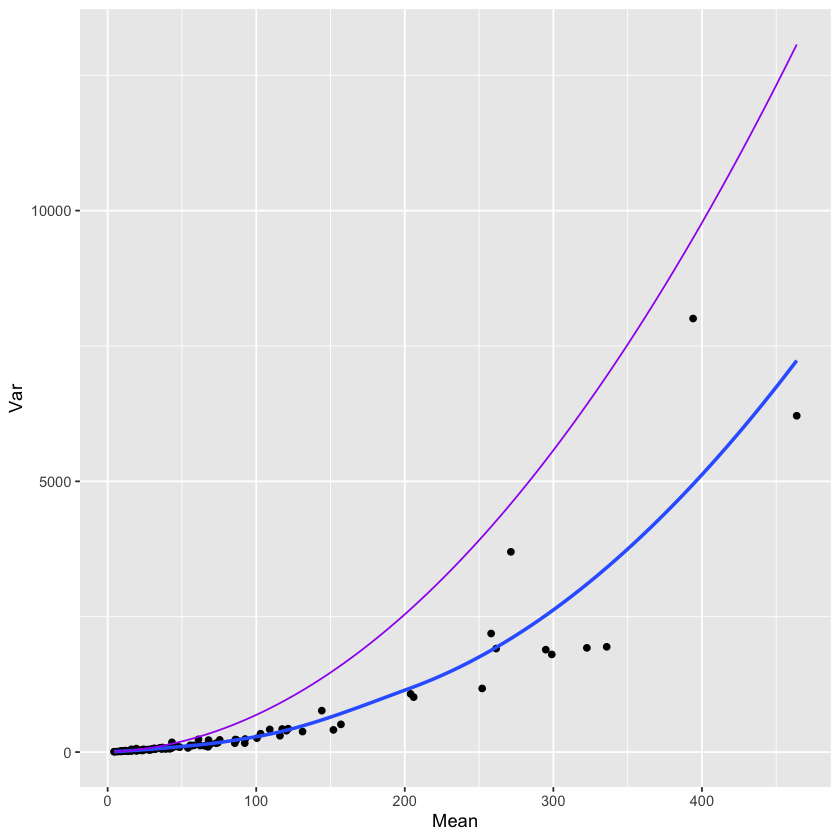

In [37]:
ggplot( crash_stats %>% filter( Mean < 500) , aes(x=Mean,y=Var)) + 
  geom_point() + 
  geom_smooth( level=0 ) +
  geom_function(fun = function(x) x + alpha*x^2, color="purple" )

## Modeling monthly births, take 2

In [ ]:
ggplot( births_apr_2016, aes(log(Pop2010),births)) + 
  geom_point() + 
  geom_smooth(method="glm", method.args=list(family="poisson"), color="purple") + 
  geom_smooth(method="glm.nb", color="blue") + ylim(0,6000)

In [ ]:
births_apr_2016_nb_fit <- glm.nb( births ~ log(Pop2010), data=births_apr_2016 )
( theta <- births_apr_2016_nb_fit$theta )
( alpha <- 1/theta )
summary( births_apr_2016_nb_fit )

Using all of the births data, the NB2 model is
$$ \text{Average number of births} ~ = ~ 0.000156 \times \left( \text{Population} \right)^{1.08339} \ , $$

with a dispersion parameter of $\alpha ~ = ~ 0.0628$.